In [2]:
from query_tracks import * #this script already imports other libraries and modules (i.e., geopandas and db_utils)
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx

from datetime import datetime

sns.set_context('paper')

In [2]:
WEB_MERCATOR_EPSG = 3857

def plot_with_labels(gdf, label_column, xlim=None, ylim=None):
    gdf_web = gdf.to_crs(epsg=WEB_MERCATOR_EPSG) #convert to Web Mercator projection so it lines up with the contextily basemap tiles
    ax = gdf_web.plot(figsize=(10, 10), alpha=0.5, edgecolor='darkslateblue')

    # Show BC unit numbers
    gdf_web['center'] = gdf_web.geometry.representative_point()
    centroids = gdf_web.copy()
    centroids.set_geometry('center', inplace = True)
    for x, y, label in zip(centroids.geometry.x, centroids.geometry.y, centroids[label_column]):
        plt.text(x - 6000, y - 6000, label, fontsize = 12)
    
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)
        
    # Add basemap
    ctx.add_basemap(ax, source=ctx.providers.Esri.WorldShadedRelief)
    ax.set_axis_off()
    
    return ax

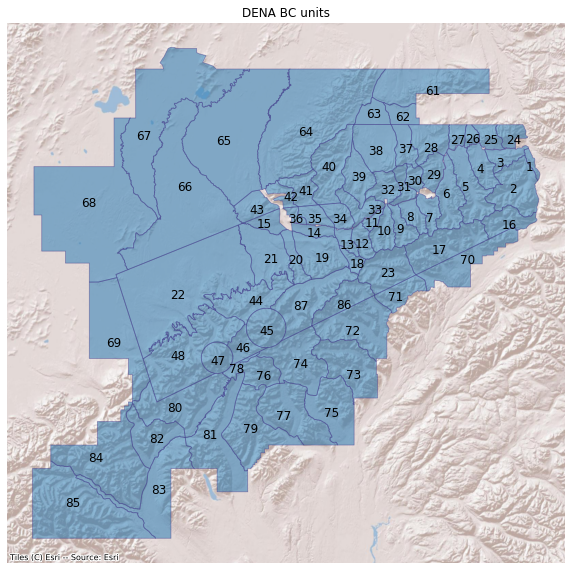

In [27]:
# Get the data for the mask
BC_UNITS_PATH = r"sample_data\bc_units.geojson"
bc_units = gpd.read_file(BC_UNITS_PATH)

# Plot it
ax = plot_with_labels(bc_units, 'Unit')
_ = ax.set_title('DENA BC units', fontsize=12)

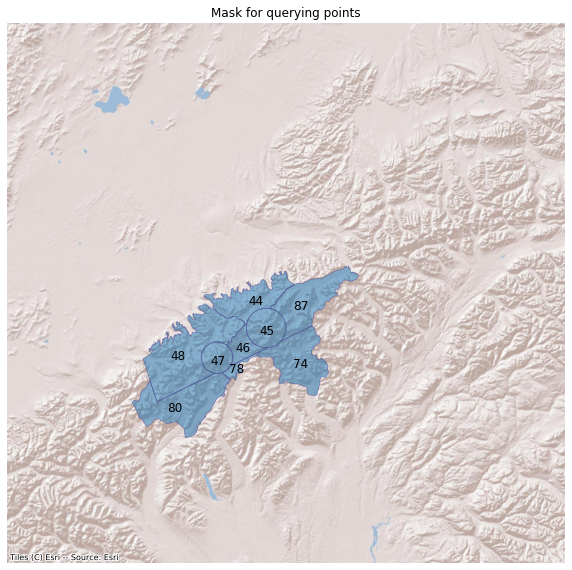

In [15]:
# Get all units that touch Denali and Foraker's units (45 and 47, respectively)
denali_foraker = bc_units.loc[bc_units['Unit'].isin([45, 47])]
mask_units = bc_units.loc[bc_units.geometry.touches(denali_foraker.geometry.unary_union) | bc_units['Unit'].isin([45, 47])]

# Plot the mask
x_axis_range = ax.get_xlim()
y_axis_range = ax.get_ylim()
ax = plot_with_labels(mask_units, 'Unit', xlim=x_axis_range, ylim=y_axis_range)
_ = ax.set_title('Mask for querying points', fontsize=12)

In [3]:
'''
Show the doc string for the query_tracks function. This describes each parameter. 
The query_tracks script can be called directly from the command line, but most of the meat is 
in a function also called "query_tracks." The function can be called from another script 
to integrate its functionality more seamlessly than the main function, which is intended to be 
run from the command line.
'''
print(query_tracks.__doc__)


    Query the overflights database with specified parameters. Results are returned as a GeoPandas.GeoDataFrame instance.

    :param start_date:      ISO date string indicating the beginning of the date range to query within (YYYY-mm-dd)
    :param end_date:        ISO date string indicating the end of the date range to query within
    :param connection_txt:  [optional] path to a text file containing postgres connection params for the overflights DB.
                            The text file must be readable by db_utils.connect_db(). If engine is not given,
                            connection_txt must be specified.
    :param engine:          [optional] SQLAlchemy Engine instance for connecting to the overflights DB. If
                            connection_txt is not given, engine must be specified.
    :param table:           [optional] string representing the name of the table to return geometries from overflights
                            DB. Options are either 'flight_poin

In [6]:
CONNECTION_TXT = r"..\..\config_files\connection_info.txt" # db connection parameters.

# Create a SQLAlchemy database engine. This isn't a connection to the DB, 
#  but a connection can be established with engine.connect(). Alternatively,
#  you can just pass the connection_txt path to the query tracks function
#  and it will create the engine for you. The advantage to creating the engine
#  yourself is that you can re-use it if you want to query the DB multiple times
#  Note also that db_utils is a module written for this project with convenience 
#  functions for accessing and getting info from the database
engine = db_utils.connect_db(CONNECTION_TXT) 

# Get all track points in the database from the beginning of 2019 to now
track_points = query_tracks('2019-1-1', datetime.now().strftime('%Y-%m-%d'), engine=engine, mask=mask_units)

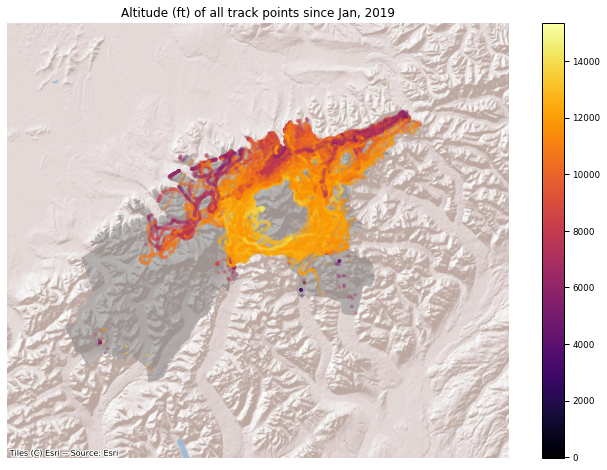

In [25]:
# Show the extent of the mask
ax = gpd.GeoSeries([mask_units.to_crs(epsg=WEB_MERCATOR_EPSG).unary_union])\
        .plot(color='gray', alpha=0.5, figsize=(12, 8))

# Plot the points
track_points_web = track_points.to_crs(epsg=WEB_MERCATOR_EPSG)
track_points_web.plot(column='altitude_ft', 
                      cmap='inferno', 
                      alpha=0.3, 
                      markersize=8,
                      legend=True,
                      ax=ax)

# If the map is too zoomed in, getting the map tiles throws an error. So expand the extent
min_x, min_y, max_x, max_y = track_points_web.geometry.total_bounds
extent_buffer = 50000
ax.set_xlim([min_x - extent_buffer, max_x + extent_buffer])
ax.set_ylim([min_y - extent_buffer, max_y + extent_buffer])

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldShadedRelief)
ax.set_axis_off()
_ = ax.set_title('Altitude (ft) of all track points since Jan, 2019', fontsize=12)